# VisionHomework4

## CIFAR NETWORK - We managed to achieve 10% accuracy. Running this code takes a very very long time. This NN has a lot of room for improvement in terms of optimization.

### Helper Functions

In [1]:
import cPickle
import numpy as np
from scipy.special import expit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline

def sig(x):
    return expit(x)

def deriv_sig(x):
    return sig(x)*(1-sig(x))

def gaus_ran(n, shape):
    return np.random.normal (0, 1/n**(.5), shape)

def unpickle(file):  
  fo = open(file, 'rb')
  dict = cPickle.load(fo)
  fo.close()
  return dict

# From mnist_loader.py
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

d = unpickle('data_batch_1')
x = np.split((d['data'].transpose() / 255.0), len(d['labels']), axis = 1)

## This averages RGB to grayscale
x2=[]
for iter in x:
    a1,a2,a3 = np.split(iter,3)
    x2.append ((a1+a2+a3)/3.0)

y = [vectorized_result(i) for i in d['labels']]
cifar_training_data = zip(x2, y)

d = unpickle('test_batch')
x = np.split((d['data'].transpose() / 255.0), len(d['labels']), axis = 1)

x2=[]
for iter in x:
    a1,a2,a3 = np.split(x[0],3)
    x2.append ((a1+a2+a3)/3.0)

cifar_test_data = zip(x2, d['labels'])

In [ ]:
import cPickle
def unpickle(file):  
  fo = open(file, 'rb')
  dict = cPickle.load(fo)
  fo.close()
  return dict

# From mnist_loader.py
def vectorized_result(j):
    """Return a 10-dimensional unit vector with a 1.0 in the jth
    position and zeroes elsewhere.  This is used to convert a digit
    (0...9) into a corresponding desired output from the neural
    network."""
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

d = unpickle('data_batch_1')
x = np.split((d['data'].transpose() / 255.0), len(d['labels']), axis = 1)

y = [vectorized_result(i) for i in d['labels']]
cifar_training_data = zip(x, y)

d = unpickle('test_batch')
x = np.split((d['data'].transpose() / 255.0), len(d['labels']), axis = 1)

cifar_test_data = zip(x, d['labels'])

## Hyperparameters

In [2]:
# Learning Rate
alpha = 2.3
epsilon = 0.001
maximum_error_permitted = 1.1
maximum_epochs = 4000

## Input and Output

In [3]:
x_s=[]
y_s=[]
for i in range (1000):
    x_s.append (cifar_training_data[i][0])
    y_s.append (cifar_training_data[i][1])
    
no_of_x_s = len(x_s[0])
no_of_samples = len(x_s)
assert len(x_s) == len(y_s)

## Number of Layers and Neurons & Initialization

In [4]:
no_of_neurons_each_layer = [100,10]
no_of_layers = len (no_of_neurons_each_layer)

# Initialize the weights neuron and for each layer
W_s=[]
W_s.append (gaus_ran(no_of_samples, (no_of_neurons_each_layer[0],no_of_x_s)))
for i in range(1,len(no_of_neurons_each_layer)):
    W_s.append (gaus_ran(no_of_samples, (no_of_neurons_each_layer[i],no_of_neurons_each_layer[i-1])))

b_s=[]
for l in no_of_neurons_each_layer:
    b_s.append (gaus_ran(no_of_samples, (l,1)))

## Learn and Running the Network

In [5]:
def learn (in_W_s, in_b_s):
    z_s=[]
    a_s=[]

    # FEEDFORWARD

    ## FIRST LAYER WITH X'S
    z=[]
    a=[]
    for x in x_s:
        z.append (np.dot(in_W_s[0],x) + in_b_s[0])
        a.append (sig(z[-1]))
    z_s.append (z)
    a_s.append (a)

    ## EVERY SUBSEQUENT LAYER WITH PREVIOUS OUTPUT
    for i in range (1, no_of_layers):
        z=[]
        a=[]
        for j in range (no_of_samples):
            z.append (np.dot(in_W_s[i],a_s[-1][j]) + in_b_s[i])
            a.append (sig(z[-1]))
        z_s.append (z)
        a_s.append (a)

    # BACKPROPAGATION

    ## LAST: DELTA L
    delta_s=[]

    delta=[]
    for i in range (no_of_samples):
        delta.append ((a_s[-1][i] - y_s[i]) * deriv_sig(z_s[-1][i]))
    delta_s.append (delta)

    ## EVERY LAYER FROM L-1 to 1
    for i in range(no_of_layers-2, -1, -1): ### We start at no_of_layers-2 because -1 is the final layer
        delta=[]
        for j in range (no_of_samples):
            delta.append (np.dot (np.transpose (in_W_s[i+1]), delta_s[0][j]) * deriv_sig(z_s[i][j]))
        delta_s.insert (0,delta)

    # GRADIENT DESCENT
    sum_W_s=[]
    sum_b_s=[]
    for i in range(no_of_layers):
        sum_W_s.append (np.zeros(in_W_s[i].shape))
        sum_b_s.append (np.zeros(in_b_s[i].shape))

    out_W_s=[]
    out_b_s=[]

    for j in range(no_of_samples):
        sum_W_s[0] += np.dot (delta_s[0][j], np.transpose (x_s[j]))
        sum_b_s[0] += delta_s[0][j]
    out_W_s.append (in_W_s[0] - sum_W_s[0] * alpha / no_of_samples)
    out_b_s.append (in_b_s[0] - sum_b_s[0] * alpha / no_of_samples)

    for i in range (1, no_of_layers):
        for j in range(no_of_samples):
            sum_W_s[i] += np.dot (delta_s[i][j], np.transpose (a_s[i-1][j]))
            sum_b_s[i] += delta_s[i][j]
        out_W_s.append (in_W_s[i] - sum_W_s[i] * alpha / no_of_samples)
        out_b_s.append (in_b_s[i] - sum_b_s[i] * alpha / no_of_samples)
    
    out_ans = a_s[-1]
    
    """
    for a in a_s[-1]:
        out_ans.append (a[0])
    """
    
    return out_ans, out_W_s, out_b_s
    
def run_network (in_W_s, in_b_s):
    W_s = in_W_s
    b_s = in_b_s
    
    epoch=0
    errors = []
    while (epoch < maximum_epochs):
        ans, W_s, b_s = learn (W_s, b_s)
        sum=0
        for i in range (no_of_samples):
            temp = mean_squared_error(ans[i],y_s[i])
            #print i,temp
            sum += temp
        errors.append (sum)
        if (epoch > 0):
            if errors[epoch-1] - errors[epoch] < epsilon and errors[-1] < maximum_error_permitted:
                break
        epoch+=1
    
    if (epoch == maximum_epochs):
        print "Did not reach terminating condition. Epochs:",epoch
    else:
        print "Terminated at epoch",epoch
    print "Final output:",ans
    
    plt.plot(errors)
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.show()
    
    return errors,W_s,b_s

Did not reach terminating condition. Epochs: 4000
Final output: [array([[  1.77992630e-04],
       [  7.54316143e-02],
       [  2.28467794e-05],
       [  7.06880535e-03],
       [  1.57028369e-01],
       [  7.47715132e-04],
       [  8.93676559e-01],
       [  2.23123023e-05],
       [  1.65396528e-02],
       [  1.77986272e-04]]), array([[  6.23975448e-03],
       [  4.19223297e-02],
       [  2.01190348e-02],
       [  2.05322752e-02],
       [  3.58871741e-04],
       [  4.75480136e-03],
       [  2.07799783e-04],
       [  2.24427271e-02],
       [  3.10651692e-03],
       [  2.06613242e-05]]), array([[  3.47970683e-02],
       [  5.87021517e-04],
       [  3.06025500e-05],
       [  1.70681043e-02],
       [  1.16143829e-02],
       [  6.55075856e-03],
       [  1.11439665e-05],
       [  8.94637985e-02],
       [  1.19523264e-02],
       [  9.95209186e-01]]), array([[  6.88933194e-06],
       [  5.83131135e-04],
       [  3.10056556e-04],
       [  9.65468343e-02],
       [  7

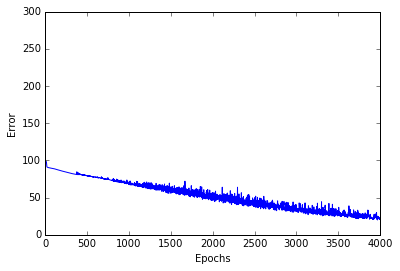

In [6]:
errors,out_W_s,out_b_s = run_network(W_s,b_s)

In [8]:
#len (test_data) # 10000
test_x_s = []
test_y_s = []
for i in range (10000):
    test_x_s.append (cifar_test_data[i][0])
    test_y_s.append (cifar_test_data[i][1])

In [11]:
def test (in_x_s, in_y_s, in_W_s, in_b_s):
    z_s=[]
    a_s=[]

    # FEEDFORWARD

    ## FIRST LAYER WITH X'S
    z=[]
    a=[]
    for x in in_x_s:
        z.append (np.dot(in_W_s[0],x) + in_b_s[0])
        a.append (sig(z[-1]))
    z_s.append (z)
    a_s.append (a)

    ## EVERY SUBSEQUENT LAYER WITH PREVIOUS OUTPUT
    for i in range (1, no_of_layers):
        z=[]
        a=[]
        for j in range (len (in_x_s)):
            z.append (np.dot(in_W_s[i],a_s[-1][j]) + in_b_s[i])
            a.append (sig(z[-1]))
        z_s.append (z)
        a_s.append (a)

    #print np.argmax (a_s[-1][0])
    #print in_y_s[0]
    
    number_of_correct_output = 0.0
    for i in range (len(in_x_s)):
        output = np.argmax (a_s[-1][i])
        #print "output",output
        correct_ans = in_y_s[i]
        #print "correct_ans",correct_ans
        if output == correct_ans:
            number_of_correct_output += 1    
    print "Our accuracy is",number_of_correct_output / len(in_x_s)
    
    return a_s[-1]
    
out_ans = test (test_x_s, test_y_s, out_W_s, out_b_s)

Our accuracy is 0.1
